# Downloading the dataset from Kaggle

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

In [ ]:
! kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

In [ ]:
! mkdir input

! unzip twitter-entity-sentiment-analysis.zip -d input

# Importing dependencies

In [147]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.random.set_seed(26)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


import itertools 


In [187]:
train_df = pd.read_csv('./input/twitter_training.csv')
train_df.iloc[:, -1] = train_df.iloc[:, -1].astype(str)

In [149]:
train_df.tail()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
74676,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74677,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74678,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74679,9200,Nvidia,Positive,Just realized between the windows partition of...
74680,9200,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [174]:
train_df['Positive'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [189]:
train_df = train_df[train_df['Positive'] != 'Irrelevant']

# Label Encoding

In [190]:
to_replace = {'Positive' : {'Negative' : 0, 'Neutral' : 0, 'Positive' : 1}}
train_df.replace(to_replace, inplace = True)
train_df['Positive'].unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


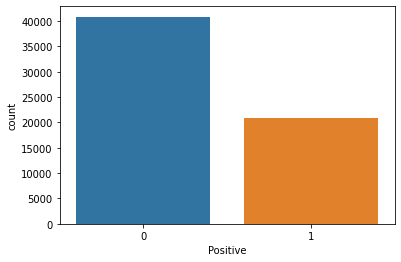

In [191]:
sns.countplot(train_df['Positive'])

There are alot more zeroes in the dataset after replacement, because positive sentiments should be focused on more.

In [152]:
sentences = train_df.iloc[:, -1]
labels = train_df['Positive']

Separate features from labels

# Split train and test

In [154]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.30, random_state = 26)

# Fitting the Tokenizer

In [155]:
num_words = 10000
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)

tokenizer.fit_on_texts(X_train)

# Creating padded sequences using the fitted tokenizer

In [156]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = np.array(pad_sequences(training_sequences, maxlen = 100, padding = 'post', truncating = 'post'))

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = np.array(pad_sequences(testing_sequences, maxlen = 100, padding = 'post', truncating = 'post'))

# Creating the model (sequentially)

In [157]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words, 16, input_length = 100),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Model compilation

In [192]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [158]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_3   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 24)                408       
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


# Creating the callback

In [159]:
acc_threshold = 0.94

class CustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = None):
    if (logs['accuracy'] is not None and logs['accuracy'] >= acc_threshold):
      print('\nREACHED ACCURACY THRESHOLD, TRAINING WILL BE STOPPED...')
      self.model.stop_training = True

callbacks = CustomCallback()

# Model training

In [160]:
history = model.fit(training_padded, y_train, epochs = 30, validation_data = (testing_padded, y_test), verbose = 1, callbacks = [callbacks])

Epoch 1/30
1350/1350 [==============================] - 8s 5ms/step - loss: 0.5602 - accuracy: 0.7099 - val_loss: 0.4460 - val_accuracy: 0.7993
Epoch 2/30
1350/1350 [==============================] - 7s 5ms/step - loss: 0.3748 - accuracy: 0.8358 - val_loss: 0.3867 - val_accuracy: 0.8265
Epoch 3/30
1350/1350 [==============================] - 6s 4ms/step - loss: 0.3055 - accuracy: 0.8729 - val_loss: 0.3442 - val_accuracy: 0.8559
Epoch 4/30
1350/1350 [==============================] - 7s 5ms/step - loss: 0.2651 - accuracy: 0.8900 - val_loss: 0.3381 - val_accuracy: 0.8590
Epoch 5/30
1350/1350 [==============================] - 7s 5ms/step - loss: 0.2370 - accuracy: 0.9026 - val_loss: 0.3391 - val_accuracy: 0.8619
Epoch 6/30
1350/1350 [==============================] - 6s 5ms/step - loss: 0.2185 - accuracy: 0.9089 - val_loss: 0.3201 - val_accuracy: 0.8638
Epoch 7/30
1350/1350 [==============================] - 7s 5ms/step - loss: 0.2053 - accuracy: 0.9142 - val_loss: 0.3206 - val_accuracy:

# Model evaluation on validation set

In [161]:
test_df = pd.read_csv('./input/twitter_validation.csv')
test_df.iloc[:, -1] = test_df.iloc[:, -1].astype(str)

test_df = test_df[test_df['Irrelevant'] != 'Irrelevant']
test_to_replace = {'Irrelevant' : {'Negative' : 0, 'Neutral' : 0, 'Positive' : 1}}
test_df.replace(test_to_replace, inplace = True)

test_sentences = test_df.iloc[:, -1].tolist()

test_labels = np.array(test_df['Irrelevant'].tolist(), dtype = np.float32)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen = 100, padding = 'post', truncating = 'post')
test_pred = model.predict(test_padded)

results = model.evaluate(test_padded, test_labels, batch_size = 128)

7/7 [==============================] - 0s 4ms/step - loss: 0.1522 - accuracy: 0.9626


In [162]:
print(f'ACCURACY ON TEST DATASET: {int(results[1] * 100)}%')

ACCURACY ON TEST DATASET: 96%


# Playground

In [165]:
def test_sentiment(sentence):
  z = []

  z.append(sentence)
  sentence = z
  func_seq = tokenizer.texts_to_sequences(sentence)
  func_padded = pad_sequences(func_seq, maxlen = 100, padding = 'post', truncating = 'post')
  print(model.predict(func_padded))

sent_input = input('Enter sentence for sentiment analysis: ')
test_sentiment(sent_input)

Enter sentence for sentiment analysis: i love you
[[0.9610832]]


In [166]:
sent_input = input('Enter sentence for sentiment analysis: ')
test_sentiment(sent_input)

Enter sentence for sentiment analysis: i hate you
[[0.02350268]]


# Visualizing model evaluation

In [167]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
  
    cm = cm / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

  

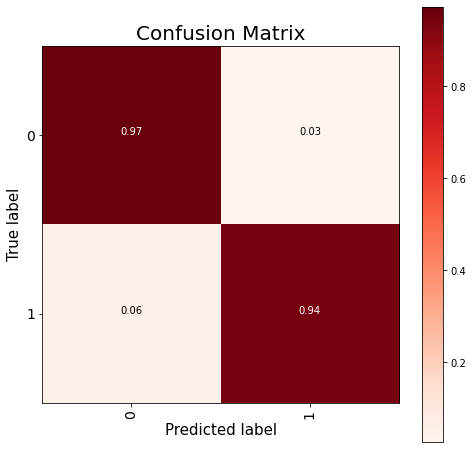

In [168]:
conf_y_true = test_labels
conf_y_pred = test_pred.round()

cmf_matrix = confusion_matrix(conf_y_true, conf_y_pred)

plt.figure(figsize = (8, 8))
plot_confusion_matrix(cmf_matrix, classes = y_train.unique(), title = "Confusion Matrix")

In [169]:
print(classification_report(conf_y_true, conf_y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       551
         1.0       0.95      0.94      0.94       277

    accuracy                           0.96       828
   macro avg       0.96      0.96      0.96       828
weighted avg       0.96      0.96      0.96       828



In [170]:
accuracy_score(conf_y_true, conf_y_pred)

0.9625603864734299

# Saving the model

In [171]:
model.save('model.h5')